In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PhoWord2Vec

In [ ]:
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
pip install --upgrade --force-reinstall numpy scipy gensim pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 249.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.9 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 21.9 MB/s eta 0:00:00
 

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from gensim.models import KeyedVectors # Hoặc Word2Vec nếu tải full model

### --- 1. Load và chuẩn bị dữ liệu ---

In [15]:
try:
    df1 = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/train_data.csv')
    df2 = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/generated_data.csv')
    df = pd.concat([df1, df2], ignore_index=True)
    print("Data loaded successfully.")
    # Thêm dòng này để đảm bảo bạn có đủ dữ liệu cho split
    if len(df) < 20: # Cần đủ dữ liệu để chia train/val/test
         raise ValueError("Not enough data to split. Need at least ~20 samples.")
except FileNotFoundError:
    print("Warning: 'comments.csv' not found. Using sample data.")
    # DataFrame mẫu (đảm bảo đủ dữ liệu)
    data = {'product_id': ['honor-x8b', 'honor-x8b', 'honor-x8b', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12'] * 3, # Nhân dữ liệu mẫu lên
            'comment': ['Đừng mua, ko có linh kiện.', 'Mua online bên này báo ngoài ip ra thì hàng ko có full box...', 'Mạng yếu hay mất sóng...', 'Mua máy lướt được 2 hôm đã lỗi loa ngoài...', 'Mới mua mà dễ nóng quá...', 'Hàng trưng bày. Sạc 4x lần...', 'Mặt kính cảm ứng cường lực nhưng ko chống sước...', 'Mai mốt mang đi bảo hành đây...', 'Mới mua được 3 tháng bây giờ phát hiện ra bức xạ...', 'Mới mua được 1 tháng thì xảy ra tình trạng tụt pin...', 'Bắt mạng rất yếu.', 'Tệ pin dại quá'] * 3,
            'comment_clean_stage1': ['đừng mua, không có linh kiện.', 'mua online bên này báo ngoài iphone ra thì hàng không có full box...', 'mạng yếu hay mất sóng...', 'mua máy lướt được hai hôm đã lỗi loa ngoài...', 'mới mua mà dễ nóng quá...', 'hàng trưng bày. sạc 4 lần...', 'mặt kính cảm ứng cường lực nhưng không chống sước...', 'mai mốt mang đi bảo hành đây...', 'mới mua được ba tháng bây giờ phát hiện ra bức xạ...', 'mới mua được một tháng thì xảy ra tình trạng tụt pin...', 'bắt mạng rất yếu.', 'tệ pin dại quá!.'] * 3,
            'comment_clean_stage2': ['đừng mua không linh_kiện', 'mua online bên báo iphone hàng không full box máy tạm ổn hơi nhẹ hơn xiaomi tuy_nhiên gọi mạng wifi 4g đứng hình suốt mà check máy vẫn gọi ổn không phải đường truyền mạng kém không thời_gian cửa_hàng giờ gọi hỏi bảo cửa_hàng bảo_hành mới mua được hai hôm giờ muốn đổi iphone 13 được đổi không hay hỗ_trợ đổi không shop máy gọi không thấy hình chập_chờn hoài dù mạng vẫn ổn_định sao', 'mạng yếu hay mất sóng đổi máy được không', 'mua máy lướt được hai hôm lỗi loa lúc bán nhân_viên không báo lỗi loa phải gửi đi bảo_hành mất thời_gian tốn tiền dán cường_lực pda', 'mới mua mà dễ nóng quá sạc nhất_là bật máy_ảnh phút nóng', 'hàng trưng_bày sạc bốn lần mà pin tụt', 'mặt kính cảm_ứng cường_lực nhưng không chống xước dùng được hai tháng màn_hình xước không chỗ trống thua màn_hình iphone', 'mai_mốt mang đi bảo_hành tự_nhiên sọc màn cho_dù không rơi', 'mới mua được tháng phát_hiện bức_xạ đổi được không', 'mới mua được tháng xảy tình_trạng tụt pin đêm tắt toàn_bộ ứng_dụng mạng bluetooth chả nổi quá tệ', 'bắt mạng rất yếu', 'tệ pin dại quá'] * 3,
            'rating': [1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1] * 3,
            # Tạo thêm dữ liệu đa dạng hơn (chỉ là ví dụ)
            'positive': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0] ,
            'negative': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1] }
    df = pd.DataFrame(data)
    print("Using sample data.")
except ValueError as ve:
     print(f"Error: {ve}")
     exit() # Thoát nếu không đủ dữ liệu


# df['comment'] = df['comment'].fillna('').astype(str)
# labels = df[['positive', 'negative']].values
# comments = df['comment'].values

df['comment_clean_stage2'] = df['comment_clean_stage2'].fillna('').astype(str)
comments = df['comment_clean_stage2'].values

Data loaded successfully.


### --- 2. Tokenization ---

In [16]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300
# EMBEDDING_DIM sẽ được xác định bởi mô hình Word2Vec tải về

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

# Save tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(comments)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
data_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Found 2922 unique tokens.


### --- 3. Tải Word2Vec và Tạo Embedding Matrix ---

In [17]:
W2V_BIN_PATH  = '/content/drive/MyDrive/Kì 7/NLP/project/word2vec_vi_words_100dims.bin' # <<< THAY ĐỔI ĐƯỜNG DẪN NÀY cho đúng file Word2Vec của bạn
EMBEDDING_DIM = None # Sẽ lấy từ model W2V
embedding_matrix = None

print(f"\nLoading Word2Vec model from: {W2V_BIN_PATH}...")
try:
    # Load file .bin
    word2vec_model = KeyedVectors.load_word2vec_format(W2V_BIN_PATH, binary=True, unicode_errors='ignore')
    # Dòng load file .model có thể xóa hoặc comment lại nếu bạn không dùng
    # from gensim.models import Word2Vec
    # word2vec_model = Word2Vec.load(W2V_PATH).wv

    print("Word2Vec model loaded successfully.")
    EMBEDDING_DIM = word2vec_model.vector_size
    print(f"Word2Vec embedding dimension: {EMBEDDING_DIM}")

    # Tạo embedding matrix
    # Lấy số lượng token từ tokenizer, giới hạn bởi MAX_NUM_WORDS
    num_tokens = min(MAX_NUM_WORDS, len(word_index) + 1) # +1 vì word_index bắt đầu từ 1
    embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
    hits = 0
    misses = 0
    for word, i in word_index.items():
        if i >= num_tokens: # Chỉ xử lý các từ trong giới hạn MAX_NUM_WORDS
            continue
        try:
            # Lấy vector từ mô hình đã tải
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector # Gán vector vào đúng vị trí index
            hits += 1
        except KeyError:
            # Từ không có trong W2V -> giữ nguyên là vector 0 (hoặc xử lý khác nếu muốn)
            misses += 1
            # print(f"Word '{word}' not in Word2Vec vocabulary.") # Bỏ comment nếu muốn xem từ nào bị miss
    print(f"Created embedding matrix for {num_tokens-1} tokens ({hits} words found, {misses} words missing).") # -1 vì index 0 không dùng

except FileNotFoundError:
    print(f"!!! Error: Word2Vec model file not found at '{W2V_BIN_PATH}'.")
    print("!!! Will use a trainable Embedding layer instead.")
    EMBEDDING_DIM = 128 # Đặt lại giá trị mặc định
    embedding_matrix = None # Đảm bảo embedding_matrix là None
except Exception as e:
    print(f"!!! Error loading Word2Vec model: {e}")
    print("!!! Will use a trainable Embedding layer instead.")
    EMBEDDING_DIM = 128 # Đặt lại giá trị mặc định
    embedding_matrix = None # Đảm bảo embedding_matrix là None


Loading Word2Vec model from: /content/drive/MyDrive/Kì 7/NLP/project/word2vec_vi_words_100dims.bin...
Word2Vec model loaded successfully.
Word2Vec embedding dimension: 100
Created embedding matrix for 2922 tokens (2553 words found, 369 words missing).


### --- 4. Chia dữ liệu

In [18]:
# Đảm bảo đủ dữ liệu sau khi load/tạo mẫu
if len(data_padded) < 5:
    print("Error: Not enough data samples after processing to perform train/val/test split.")
    exit()

# Ưu tiên train nhiều -> 80% train, 10% val, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    data_padded, labels, test_size=0.1, random_state=42, stratify=labels.sum(axis=1)
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp.sum(axis=1)
)


print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Val labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (3263, 300), Train labels shape: (3263, 2)
Validation data shape: (408, 300), Val labels shape: (408, 2)
Test data shape: (408, 300), Test labels shape: (408, 2)


### --- 5. Định nghĩa lại các mô hình để sử dụng Embedding Matrix ---

In [24]:
def build_model_with_embedding(model_type, vocab_size, embedding_dim, max_length, num_labels=2, embedding_matrix=None):
    model = Sequential()
    if embedding_matrix is not None:
        print(f"Building {model_type} with pre-trained Word2Vec Embedding (non-trainable)")
        input_dim_emb = embedding_matrix.shape[0]
        output_dim_emb = embedding_matrix.shape[1]
        model.add(Embedding(input_dim=input_dim_emb, output_dim=output_dim_emb,
                            weights=[embedding_matrix], input_length=max_length, trainable=True))
    else:
        print(f"Building {model_type} with trainable Embedding layer")
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            input_length=max_length, trainable=True))
    rnn_layer_type = LSTM if model_type == 'BiLSTM' else GRU
    model.add(Bidirectional(rnn_layer_type(96, return_sequences=True)))
    model.add(Bidirectional(rnn_layer_type(48)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels, activation='sigmoid'))
    model.build(input_shape=(None, max_length))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [20]:
# --- HÀM VẼ CONFUSION MATRIX ---
def plot_multilabel_confusion_matrices(y_true, y_pred, labels_names):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    n_labels = len(labels_names)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4.5)) # Tăng chiều cao một chút
    if n_labels == 1:
        axes = [axes]
    for i, label_name in enumerate(labels_names):
        cm = mcm[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=[f'Not {label_name}', f'{label_name}'],
                    yticklabels=[f'Not {label_name}', f'{label_name}'])
        axes[i].set_title(f'Confusion Matrix for: {label_name}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# --- HÀM VẼ LỊCH SỬ HUẤN LUYỆN ---
def plot_history_separate_models(histories_dict, accuracy_metric='binary_accuracy'):
    """
    Vẽ biểu đồ Training & Validation Accuracy và Training & Validation Loss
    cho từng model trên một figure riêng biệt (hoặc các subplot riêng).

    Args:
        histories_dict (dict): Dictionary chứa history object (dưới dạng dict) của các model.
                               Ví dụ: {'BiLSTM_W2V': model.history.history, ...}
        accuracy_metric (str): Tên của metric accuracy trong history.
    """
    num_models = len(histories_dict)
    if num_models == 0:
        print("No histories to plot.")
        return

    for model_name, history_data in histories_dict.items():
        if not history_data: # Bỏ qua nếu history_data rỗng hoặc None
            print(f"Skipping plot for {model_name} due to empty history data.")
            continue

        plt.figure(figsize=(14, 5)) # Tạo một figure mới cho mỗi model

        # --- Subplot 1: Accuracy for the current model ---
        plt.subplot(1, 2, 1)
        has_accuracy_data = False
        if accuracy_metric in history_data and f'val_{accuracy_metric}' in history_data:
            plt.plot(history_data[accuracy_metric], label='Train Accuracy')
            plt.plot(history_data[f'val_{accuracy_metric}'], label='Validation Accuracy', linestyle='--')
            has_accuracy_data = True
        elif 'accuracy' in history_data and 'val_accuracy' in history_data: # Fallback
            print(f"Warning: '{accuracy_metric}' not found for {model_name}, using 'accuracy'.")
            plt.plot(history_data['accuracy'], label='Train Accuracy')
            plt.plot(history_data['val_accuracy'], label='Validation Accuracy', linestyle='--')
            has_accuracy_data = True

        if has_accuracy_data:
            plt.title(f'Accuracy for {model_name}')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
        else:
            plt.title(f'Accuracy Data Missing for {model_name}')
            print(f"Warning: Accuracy metrics ('{accuracy_metric}' or 'accuracy') not found in history for {model_name}.")


        # --- Subplot 2: Loss for the current model ---
        plt.subplot(1, 2, 2)
        has_loss_data = False
        if 'loss' in history_data and 'val_loss' in history_data:
            plt.plot(history_data['loss'], label='Train Loss')
            plt.plot(history_data['val_loss'], label='Validation Loss', linestyle='--')
            has_loss_data = True

        if has_loss_data:
            plt.title(f'Loss for {model_name}')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
        else:
            plt.title(f'Loss Data Missing for {model_name}')
            print(f"Warning: Loss metrics ('loss', 'val_loss') not found in history for {model_name}.")

        plt.suptitle(f'Training History for Model: {model_name}', fontsize=16) # Tiêu đề chung cho figure của model
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Điều chỉnh layout để tiêu đề chung không bị che
        plt.show()

# --- HÀM DỰ ĐOÁN ---
def predict_sentiment(text, model, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence, verbose=0)
    labels_arr = (prediction > 0.5).astype(int)[0]
    predicted_dict = {"positive": int(labels_arr[0]), "negative": int(labels_arr[1])}
    return predicted_dict, prediction[0]


### --- 6. Huấn luyện và Đánh giá ---

In [25]:
if embedding_matrix is not None:
    effective_vocab_size = embedding_matrix.shape[0]
    effective_embedding_dim = embedding_matrix.shape[1]
else:
    effective_vocab_size = MAX_NUM_WORDS
    effective_embedding_dim = EMBEDDING_DIM

models_to_train = {
    "BiLSTM_W2V": build_model_with_embedding('BiLSTM', effective_vocab_size, effective_embedding_dim, MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix),
    "BiGRU_W2V": build_model_with_embedding('BiGRU', effective_vocab_size, effective_embedding_dim, MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix)
}
if embedding_matrix is None:
     models_to_train = {
        "BiLSTM_TrainableEmb": models_to_train.pop("BiLSTM_W2V"), # Dùng pop để đổi tên key
        "BiGRU_TrainableEmb": models_to_train.pop("BiGRU_W2V")
     }

results = {}
histories = {}
training_times = {}
epoch_durations = {}
avg_epoch_durations = {}

BATCH_SIZE = 32
EPOCHS = 50

Building BiLSTM with pre-trained Word2Vec Embedding (non-trainable)
Building BiGRU with pre-trained Word2Vec Embedding (non-trainable)


In [26]:
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

for model_name, model in models_to_train.items():
    model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 300, 100)       │       292,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 300, 192)       │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 96)             │        92,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,310 (2.06 MB)

 Trainable params: 539,310 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 300, 100)       │       292,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 300, 192)       │       114,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 96)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,214 (1.83 MB)

 Trainable params: 479,214 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
if 'X_train' not in locals() or X_train.shape[0] == 0 or \
   ('X_val' not in locals() or (X_val.shape[0] == 0 and ('X_temp' in locals() and len(X_temp) > 1))):
    print("\nError: Training/Validation data not available or empty. Cannot train models.")
    # Gán giá trị rỗng/NaN cho các biến lưu trữ nếu không train được
    for model_name_key in models_to_train.keys():
        histories[model_name_key] = None
        training_times[model_name_key] = np.nan
        epoch_durations[model_name_key] = []
        avg_epoch_durations[model_name_key] = np.nan
else:
    for model_name, model_instance in models_to_train.items(): # Đổi tên `model` thành `model_instance` để tránh nhầm lẫn
        print(f"\n--- Training {model_name} ---")
        # model_instance.summary() # model.build đã được gọi trong build_model_with_embedding

        early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
        model_checkpoint = ModelCheckpoint(
            filepath=f'model_checkpoints/{model_name}_best.keras',
            save_best_only=True, monitor='val_loss', mode='min'
        )
        # Định nghĩa EpochTimer ở đây hoặc ở scope toàn cục hơn nếu dùng ở nhiều nơi
        class EpochTimer(tf.keras.callbacks.Callback):
            def __init__(self):
                super().__init__()
                self.epoch_times = []
            def on_epoch_begin(self, epoch, logs=None): self.start_time = time.time()
            def on_epoch_end(self, epoch, logs=None): self.epoch_times.append(time.time() - self.start_time)
        epoch_timer_callback = EpochTimer()

        print(f"Starting training for {model_name} with {EPOCHS} max epochs...")
        overall_start_time = time.time()

        current_val_data = (X_val, y_val) if 'X_val' in locals() and X_val.shape[0] > 0 else None

        history_obj = model_instance.fit(X_train, y_train, # Sử dụng model_instance
                                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=current_val_data,
                                    callbacks=[early_stopping, model_checkpoint, epoch_timer_callback],
                                    verbose=2)
        overall_end_time = time.time()

        training_times[model_name] = overall_end_time - overall_start_time
        histories[model_name] = history_obj.history # Lưu history dict thay vì History object
        epoch_durations[model_name] = epoch_timer_callback.epoch_times

        if epoch_timer_callback.epoch_times:
            avg_epoch_durations[model_name] = np.mean(epoch_timer_callback.epoch_times)
            num_actual_epochs = len(epoch_timer_callback.epoch_times)
            print(f"Finished training {model_name}.")
            print(f"  Total training time: {training_times[model_name]:.2f} secs for {num_actual_epochs} epochs.")
            print(f"  Average time per epoch: {avg_epoch_durations[model_name]:.2f} secs.")
        else:
            print(f"Training for {model_name} did not complete any epochs.")
            avg_epoch_durations[model_name] = np.nan
            # Cũng nên gán history là None hoặc rỗng nếu không có epoch nào
            if model_name not in histories or histories[model_name] is None :
                 histories[model_name] = {}


print("Models saved in 'model_checkpoints/' directory.")
print("Training histories, times are stored in variables ending with ''.")


--- Training BiLSTM_W2V ---
Starting training for BiLSTM_W2V with 50 max epochs...
Epoch 1/50
102/102 - 10s - 96ms/step - auc: 0.7896 - binary_accuracy: 0.7069 - loss: 0.5545 - val_auc: 0.9507 - val_binary_accuracy: 0.8652 - val_loss: 0.3308
Epoch 2/50
102/102 - 9s - 85ms/step - auc: 0.9498 - binary_accuracy: 0.9010 - loss: 0.2802 - val_auc: 0.9697 - val_binary_accuracy: 0.9228 - val_loss: 0.2147
Epoch 3/50
102/102 - 5s - 50ms/step - auc: 0.9716 - binary_accuracy: 0.9401 - loss: 0.1970 - val_auc: 0.9752 - val_binary_accuracy: 0.9252 - val_loss: 0.2059
Epoch 4/50
102/102 - 4s - 41ms/step - auc: 0.9836 - binary_accuracy: 0.9583 - loss: 0.1456 - val_auc: 0.9722 - val_binary_accuracy: 0.9277 - val_loss: 0.2085
Epoch 5/50
102/102 - 6s - 55ms/step - auc: 0.9900 - binary_accuracy: 0.9663 - loss: 0.1109 - val_auc: 0.9733 - val_binary_accuracy: 0.9436 - val_loss: 0.2046
Epoch 6/50
102/102 - 6s - 61ms/step - auc: 0.9918 - binary_accuracy: 0.9717 - loss: 0.0948 - val_auc: 0.9731 - val_binary_acc


--- Evaluating models and plotting results ---

--- Evaluating BiLSTM_W2V on Test Set ---
BiLSTM_W2V Test Loss: 0.2510
BiLSTM_W2V Test Binary Accuracy: 0.9338
BiLSTM_W2V Test AUC: 0.9653

BiLSTM_W2V Detailed Test Metrics:
  Subset Accuracy (Exact Match Ratio): 0.8971
  Hamming Loss (Lower is better): 0.0662
  F1 Score (Micro): 0.9260
  F1 Score (Macro): 0.9275
  F1 Score (Samples): 0.6609
  Precision (Macro): 0.9378
  Recall (Macro): 0.9173

Classification Report (Label-wise):
              precision    recall  f1-score   support

    positive       0.96      0.94      0.95       171
    negative       0.92      0.90      0.91       198

   micro avg       0.94      0.92      0.93       369
   macro avg       0.94      0.92      0.93       369
weighted avg       0.94      0.92      0.93       369
 samples avg       0.66      0.67      0.66       369


Plotting Confusion Matrices for BiLSTM_W2V...


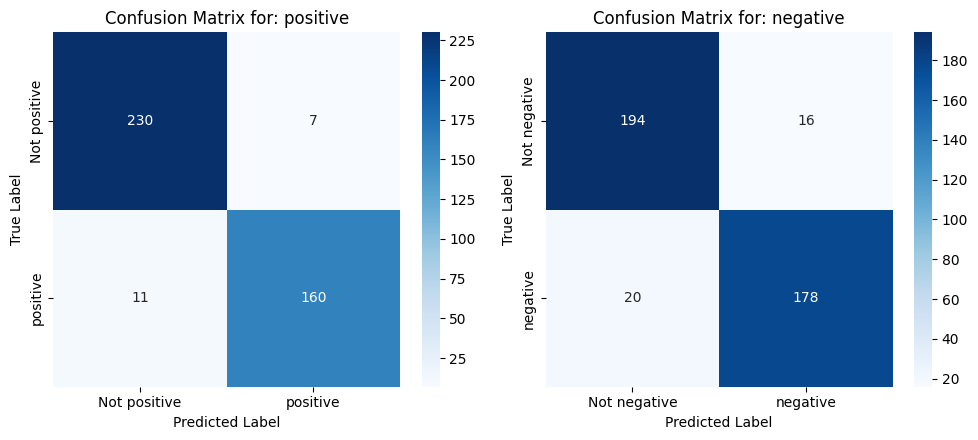


--- Evaluating BiGRU_W2V on Test Set ---
BiGRU_W2V Test Loss: 0.2531
BiGRU_W2V Test Binary Accuracy: 0.9301
BiGRU_W2V Test AUC: 0.9653

BiGRU_W2V Detailed Test Metrics:
  Subset Accuracy (Exact Match Ratio): 0.8848
  Hamming Loss (Lower is better): 0.0699
  F1 Score (Micro): 0.9237
  F1 Score (Macro): 0.9240
  F1 Score (Samples): 0.6781
  Precision (Macro): 0.9137
  Recall (Macro): 0.9346

Classification Report (Label-wise):
              precision    recall  f1-score   support

    positive       0.92      0.93      0.93       171
    negative       0.90      0.94      0.92       198

   micro avg       0.91      0.93      0.92       369
   macro avg       0.91      0.93      0.92       369
weighted avg       0.91      0.93      0.92       369
 samples avg       0.68      0.69      0.68       369


Plotting Confusion Matrices for BiGRU_W2V...


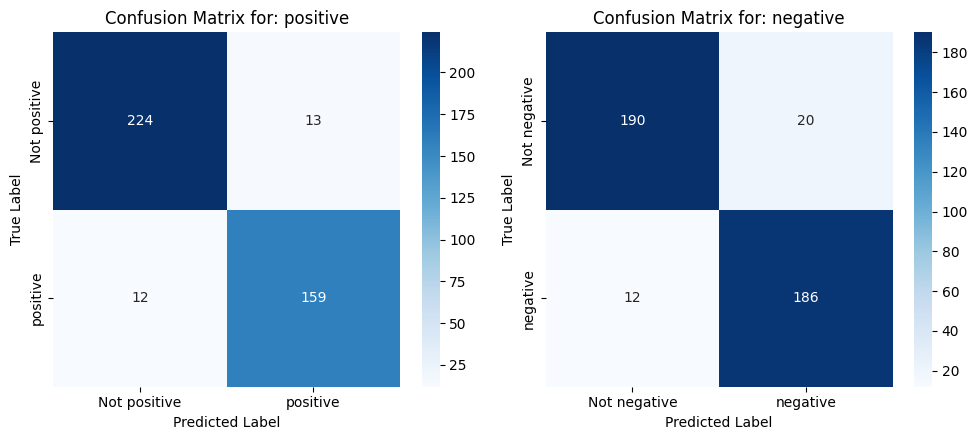

In [28]:
results = {}
prediction_times = {}

print("\n--- Evaluating models and plotting results ---")

if 'models_to_train' not in locals() or not models_to_train:
    print("Error: 'models_to_train' dictionary not found or empty. Please run Cell 1 first.")
elif 'X_test' not in locals() or X_test.shape[0] == 0:
    print("Error: Test data (X_test) not available or empty. Cannot evaluate models.")
else:
    for model_name_key in models_to_train.keys():
        print(f"\n--- Evaluating {model_name_key} on Test Set ---")
        model_path = f'model_checkpoints/{model_name_key}_best.keras'

        if not os.path.exists(model_path):
            print(f"Model file not found: {model_path}. Skipping evaluation for this model.")
            results[model_name_key] = {k: np.nan for k in ['loss', 'binary_accuracy', 'auc', 'subset_accuracy', 'hamming_loss', 'f1_micro', 'f1_macro', 'f1_samples', 'precision_macro', 'recall_macro']}
            results[model_name_key]['training_time'] = training_times.get(model_name_key, np.nan)
            results[model_name_key]['avg_epoch_time'] = avg_epoch_durations.get(model_name_key, np.nan)
            prediction_times[model_name_key] = np.nan
            continue

        try:
            best_model_loaded = tf.keras.models.load_model(model_path)

            loss, binary_acc, auc = best_model_loaded.evaluate(X_test, y_test, verbose=0)
            print(f"{model_name_key} Test Loss: {loss:.4f}")
            print(f"{model_name_key} Test Binary Accuracy: {binary_acc:.4f}")
            print(f"{model_name_key} Test AUC: {auc:.4f}")

            start_pred_time = time.time()
            y_pred_prob = best_model_loaded.predict(X_test, verbose=0)
            end_pred_time = time.time()
            prediction_times[model_name_key] = end_pred_time - start_pred_time
            y_pred = (y_pred_prob > 0.5).astype(int)

            accuracy = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            f1_micro = f1_score(y_test, y_pred, average='micro')
            f1_macro = f1_score(y_test, y_pred, average='macro')
            f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=0)
            precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

            print(f"\n{model_name_key} Detailed Test Metrics:")
            print(f"  Subset Accuracy (Exact Match Ratio): {accuracy:.4f}")
            print(f"  Hamming Loss (Lower is better): {hamming:.4f}")
            print(f"  F1 Score (Micro): {f1_micro:.4f}")
            print(f"  F1 Score (Macro): {f1_macro:.4f}")
            print(f"  F1 Score (Samples): {f1_samples:.4f}")
            print(f"  Precision (Macro): {precision_macro:.4f}")
            print(f"  Recall (Macro): {recall_macro:.4f}")
            print("\nClassification Report (Label-wise):")
            print(classification_report(y_test, y_pred, target_names=['positive', 'negative'], zero_division=0))

            # --- VẼ CONFUSION MATRIX ---
            print(f"\nPlotting Confusion Matrices for {model_name_key}...")
            try:
                plot_multilabel_confusion_matrices(y_test, y_pred, labels_names=['positive', 'negative'])
            except Exception as cm_err:
                print(f"Error plotting confusion matrix for {model_name_key}: {cm_err}")

            results[model_name_key] = {
                'loss': loss, 'binary_accuracy': binary_acc, 'auc': auc,
                'subset_accuracy': accuracy, 'hamming_loss': hamming,
                'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_samples': f1_samples,
                'precision_macro': precision_macro, 'recall_macro': recall_macro,
                'training_time': training_times.get(model_name_key, np.nan),
                'avg_epoch_time': avg_epoch_durations.get(model_name_key, np.nan),
                'prediction_time_per_batch': prediction_times.get(model_name_key, 0) / len(X_test) if len(X_test) > 0 else 0
            }
        except Exception as eval_err:
              print(f"Error evaluating model {model_name_key}: {eval_err}")
              results[model_name_key] = {k: np.nan for k in ['loss', 'binary_accuracy', 'auc', 'subset_accuracy', 'hamming_loss', 'f1_micro', 'f1_macro', 'f1_samples', 'precision_macro', 'recall_macro']}
              results[model_name_key]['training_time'] = training_times.get(model_name_key, np.nan)
              results[model_name_key]['avg_epoch_time'] = avg_epoch_durations.get(model_name_key, np.nan)
              prediction_times[model_name_key] = np.nan





--- Plotting Training Histories ---


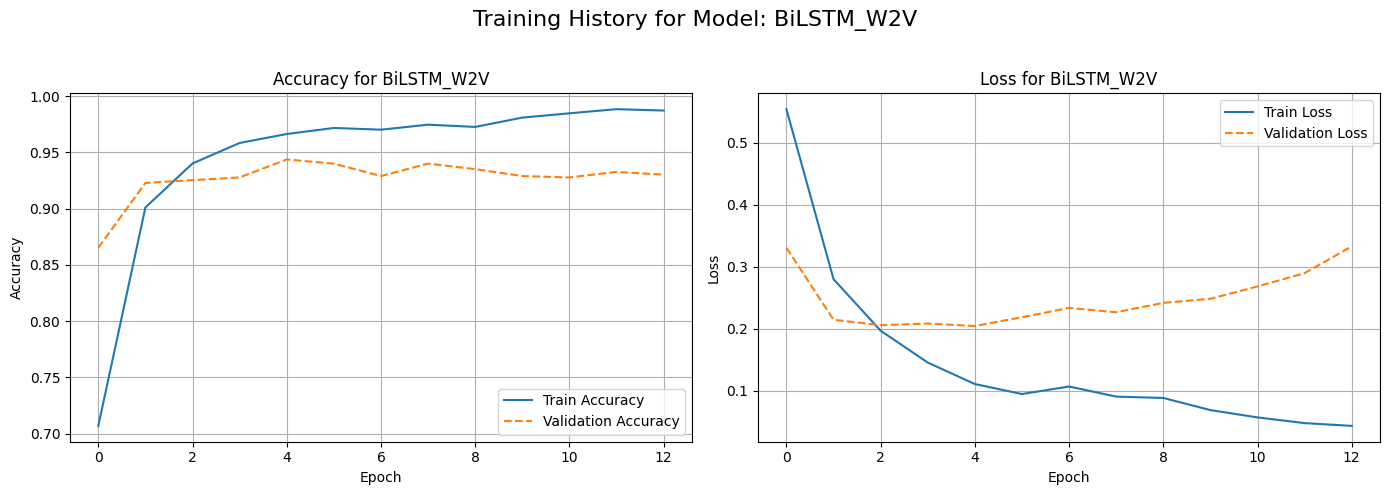

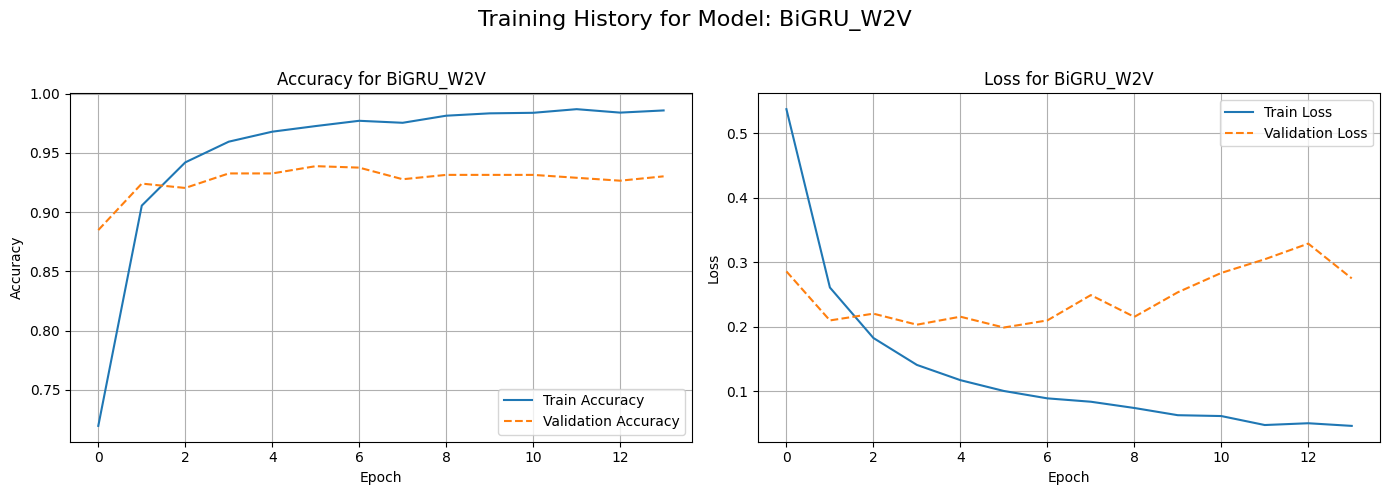

In [29]:
# --- Vẽ Lịch sử Huấn luyện ---
if 'histories' in locals() and histories:
    print("\n--- Plotting Training Histories ---")
    plot_history_separate_models(histories, accuracy_metric='binary_accuracy')
else:
    print("\nNo training histories to plot.")

In [30]:
# --- 8. Ví dụ dự đoán trên comment mới (Giữ nguyên) ---

# Hàm predict_sentiment (đã có ở code trước, copy lại nếu cần)
def predict_sentiment(text, model, tokenizer, max_length):
    # clean_text = text # Tạm thời bỏ qua làm sạch phức tạp
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence, verbose=0) # Thêm verbose=0
    labels = (prediction > 0.5).astype(int)[0]
    # Chuyển đổi kiểu dữ liệu nếu cần (ví dụ nếu đầu ra là np.int64)
    predicted_dict = {"positive": int(labels[0]), "negative": int(labels[1])}
    return predicted_dict, prediction[0]

if results: # Chỉ dự đoán nếu có model đã train và đánh giá
    try:
        # Chọn model tốt nhất dựa trên validation (hoặc test) performance để dự đoán
        # Lọc ra các model có kết quả (không phải NaN) trước khi tìm max
        valid_results_df = pd.DataFrame(results).T.dropna(subset=['f1_macro'])
        if not valid_results_df.empty:
            best_model_name = valid_results_df['f1_macro'].idxmax() # Ví dụ chọn theo F1 Macro cao nhất
            print(f"\nUsing best model for prediction: {best_model_name}")
            best_model = tf.keras.models.load_model(f'model_checkpoints/{best_model_name}_best.keras')

            # Ví dụ
            new_comment_positive = "điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm"
            new_comment_negative = "máy lag quá dùng chán không tả nổi hay bị sập nguồn"
            new_comment_mixed = "camera ổn nhưng pin tụt nhanh kinh khủng"
            new_comment_neutral = "giao hàng nhanh đúng hẹn đóng_gói cẩn_thận" # Kiểm tra lại dự đoán này
            comment1 = "thế_giới di_động có dán cường_lực honor tám không"
            comment2 = "làm ăn chán"

            for comment in [new_comment_positive, new_comment_negative, new_comment_mixed, new_comment_neutral, comment1, comment2]:
                pred_labels, pred_probs = predict_sentiment(comment, best_model, tokenizer, MAX_SEQUENCE_LENGTH) # Hàm predict_sentiment giữ nguyên
                print(f"\nComment: '{comment}'")
                print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs[0]:.3f}, {pred_probs[1]:.3f})")
                print(f"  Predicted Labels: {pred_labels}")
        else:
             print("\nCould not determine the best model as no valid results were found.")
    except Exception as pred_err:
        print(f"\nError during prediction with best model: {pred_err}")
else:
    print("\nSkipping prediction as no models were trained/evaluated successfully.")


Using best model for prediction: BiLSTM_W2V

Comment: 'điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm'
  Predicted Probabilities (Pos, Neg): (0.994, 0.005)
  Predicted Labels: {'positive': 1, 'negative': 0}

Comment: 'máy lag quá dùng chán không tả nổi hay bị sập nguồn'
  Predicted Probabilities (Pos, Neg): (0.001, 0.990)
  Predicted Labels: {'positive': 0, 'negative': 1}

Comment: 'camera ổn nhưng pin tụt nhanh kinh khủng'
  Predicted Probabilities (Pos, Neg): (0.997, 0.995)
  Predicted Labels: {'positive': 1, 'negative': 1}

Comment: 'giao hàng nhanh đúng hẹn đóng_gói cẩn_thận'
  Predicted Probabilities (Pos, Neg): (0.058, 0.174)
  Predicted Labels: {'positive': 0, 'negative': 0}

Comment: 'thế_giới di_động có dán cường_lực honor tám không'
  Predicted Probabilities (Pos, Neg): (0.003, 0.001)
  Predicted Labels: {'positive': 0, 'negative': 0}

Comment: 'làm ăn chán'
  Predicted Probabilities (Pos, Neg): (0.020, 0.850)
  Predicted Labels: {'positive': 0, 'negative': 1}
